# MINI-PROJECT 4
## Building a 1D CNN for classification of waveforms
### QINTONG LI
### Date: 13/12/2021

---

# <a id="content"></a> CONTENT

# [Introduction](#intro)
* ### Background information
* ### Background setup


# Import Data

## 1. [Import data](#data)

## 2. [Visualization](#visual)


# Analysis

## 3. [CNN 1](#1)
* ### [Building CNN](#build1)
* ### [Results](#result1)
* ### [Plots](#plot1)
* ### [Feature maps](#fm1)

## 4. [CNN 2](#2)
* ### [Building CNN](#build2)
* ### [Results](#result2)
* ### [Plots](#plot2)
* ### [Feature maps](#fm2)

# Further Study
## 5. More structures
* ### [Best CNN (citations)](#bc)


# [Discussion and Conclusion](#dc)

# <a id="intro"></a> [Introduction and Setups](#content)

This projet is about designing a 1D Convolutional Neural Net (CNN) that classifies digitised signals from two type of scintillating materials used to record particle energy. 

There are many signal processing tasks where it is important to separate the signals recorded in different categories. Due the complex features of the signals recorded, a computer vision solution is well suited for solving this problem. 

We are dealing with two type of signals: 

* **The first type** of material is an organic scintillator (PVT) with **a fast time response** of a few nanoseconds. These fasts signals are also called Electron Scintillation (ES) signals.  

* **The second type** of material is an inorganic scintillator to detect neutrons (ZnS(Ag)), one of the oldest scintillator used. When a neutron is detected, the scintillation signal **a long trail of fast pulses that slowly decreases in amplitude**. These slow signals are called Nuclear Scintillation (NS) signals. 

We are interested here to separate as well as possible each type of signal and therefore coming up with a model that is able to have a very high score at predicting each class of signal.

Numpy files for the training and testing datasets (xtrain.npy, ytrain.npy) and their labels are already prepared. Each digitised waveform is a 1000 samples long with recorded pulses starting at a fixed time around 250 samples. Some examples of how to look at each signals and their label is provided below. Both type of signals have their amplitude normalised to the smallest pulse detectable i.e. what we call the 1 Photo-electron pulse. 

<div class="alert alert-info">
<b>Building the 1-dimensional CNN to classify the waveforms</b>
    
<b>Hints for the project!</b>
* The relatively large differences between these two type of signals means the classification with simple pulse processing method yields an Area Under the curve (Integral of the ROC curve) of better than 95%. It is therefore expected that a well designed CNN provides an AUC > 95% with the aim to reach better than 99%.
* It is expected that datasets and dataloaders are implemented. Example of visualisation of plots showing features of the waveforms with some discussion is also expected. 
* The steps in designing and optimising the architecture should be clearly presented with a schematic of the final model architecture. It is important to explain why you have chosen some specific parameters or functions and don't hesitate the cite the literature if you have find the information in an article. 
* training/testing Loss and Accuracy and other parameters of the training should also be shown along with the final results. 
* Provide a plot with the output of the model for each class as well as the final ROC curve and AUC. 
* Feel free to add feature maps and other visualisation to support your discussion of performance and why
    
</div>

In [1]:
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
import copy
import pandas as pd 

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# choose your preferred font size and style here for plots
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.serif'] = 'Times'

# <a id="data"></a> [1. Import data and data processing](#content)

<div class="alert alert-info"> <p>

<b>Method</b> 

The most ideal method to import the data is to create a new class of dataset. This way the code will be more sensible and reusable. Instead of importing data manually with multiple steps for different purposes. Calling the dataset class or changing the functions in the class will imporve the efficiency significantly, especially when the raw data were complicatedly stored.
    
- Here in this project, the process of importing data is not too complex. Therefore, importing data manually is also applicable and easier to understand. Meanwhile, the code for creating a dataset class was also given as fowllowed and commented.
- First step of this process is to import raw data from the provided file for this project. It is also important to check the shape of all datasets. Therefore, it can be very helpful to print out the shape and type of the imported data.
    
</div>

In [3]:
# class CustomDataset(torch.utils.data.Dataset):

#     def __init__(self1,self2, root1,root2): # from torch.utils.data.Dataset
#         """
#         :param root: the directory where the dataset is
#         :param transform: transformation that is needed to be applied to data before it is loaded by DataLoader
#         """
#         self.root = root
#         self.transform = transform
#         self.x_data, self.y_data = self.get_entire_dataset(root, transform)


#         return

#     def __len__(self): # from torch.utils.data.Dataset
#         """
#         :return: the length of dataset, the number of data in dataset
#         """
#         return len(self.x)

#     def __getitem__(self, idx): # from torch.utils.data.Dataset
#         """
#         :param idx: index of data and corresponding label that we want to retrieve from dataset
#         :return: x_data[idx], y_data[idx]
#         """
#         x = torch.Tensor(self.x_data[idx])
#         y = torch.Tensor(self.y_data[idx])

#         return x, y

#     def get_entire_dataset(self, root, transfrom):

#         # Open and load all images in the root directory, then return those data being transformed by the given argument transform.
#         return

# dataset = CustomDataset(root, transform)
# data_loader = torch.utils.data.DataLoader(dataset)

In [4]:
# importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")

# print out the shape for futher proceesing
print(xtrain.shape,xtest.shape)
print(ytrain.shape,ytest.shape)

(12302, 1000) (3076, 1000)
(12302, 2) (3076, 2)


<div class="alert alert-info"> <p>

After printing out the shape of the arrays, next step is to find out the method to transform the given data to what is needed for further analysis. To continue the process, two tensor datasets are needed: Train and Test. Four arrays were given: xtrain, ytrain, xtest, ytest, where x is the signals mentioned in the introduction part consist of 1000 samples and y is the prepared labels for two types of signals (ES[1,0] and NS[0,1]). Therefore, the next implementation should be combining the training sets and testing sets respectively.
</div>

In [5]:
# importing the datasets
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")

#transform array into Tensors
xtrain = torch.Tensor(xtrain)
ytrain = torch.Tensor(ytrain)
xtest = torch.Tensor(xtest)
ytest = torch.Tensor(ytest)

# combine training sets and testing sets using tensor datasets
train = TensorDataset(xtrain,ytrain)
test = TensorDataset(xtest,ytest)

# use dataloader to set the batch size for each epoch
train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=60) #we can set the batch size for each interation
test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=True, batch_size=60)

# <a id="visual"></a> [2. Visualization of signal waveforms](#content)

Below we are displaying a few examples from the training set to get a feel for the variability of the signal waveforms. The signals are loaded by data loaders and seperated by `iter()` again instead of using raw data directly.

As it is shown below, the fast ES signals have labels ```[1,0]``` and the slower signals NS from neutrons have the other value ```[0,1]```. Notice that you can have some 1 PE pulses being present in the waveform for ES signals but generally not with the same density as NS signals.   

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


signal shape: torch.Size([60, 1000]) 
 label shape: torch.Size([60, 2])


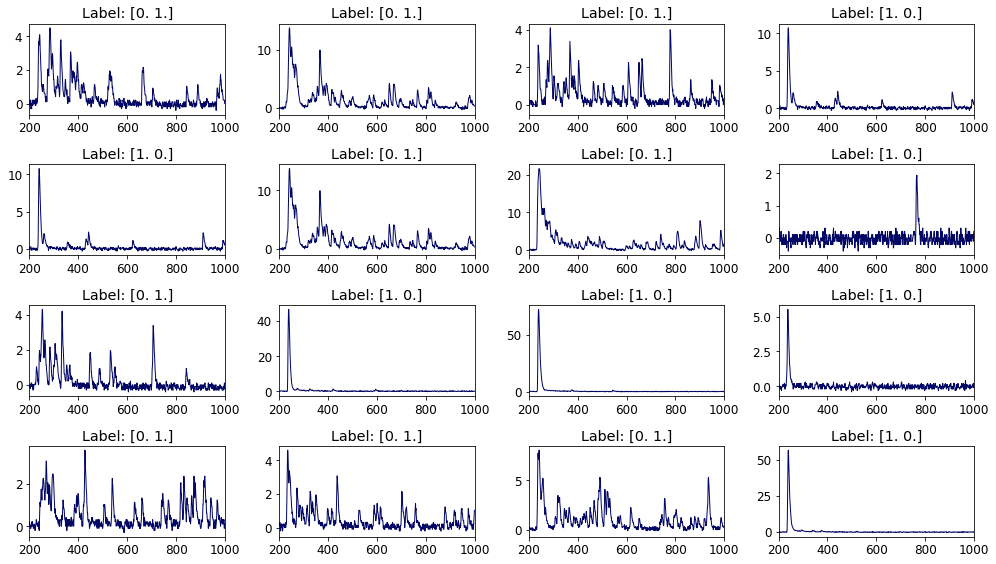

In [6]:
fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
dataiter = iter(train_loader)
xtrain_v, ytrain_v = dataiter.next()
print("signal shape:", xtrain_v.shape, "\n label shape:", ytrain_v.shape)
for i in range(0, 16):
    j = np.random.randint(0, len(xtrain_v))
    #print(j)
    ax[i].plot(xtrain_v[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Label: {}".format(ytrain_v.detach().numpy()[j]))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time
fig.tight_layout()

<div class="alert alert-danger"> <p>
<b>NB</b>

Another unavoidable implementation is to add a chanel to the data using `torch.unsqueeze()`. The chanel column was ignored because it is a single chanel source. However, it is important here since the CNN need an input which is the chanel size in this case.
</div>

In [7]:
# add 1 column for chanel size using unsqueeze
xtrain = torch.unsqueeze(xtrain, 1)
ytrain = torch.unsqueeze(ytrain, 1)

xtest = torch.unsqueeze(xtest, 1)
ytest = torch.unsqueeze(ytest, 1)

# combine training set and testing set again
train = TensorDataset(xtrain,ytrain)
test = TensorDataset(xtest,ytest)

batchsize = 200
train_loader = torch.utils.data.DataLoader(dataset=train, shuffle=True, batch_size=batchsize) #we can set the batch size for each interation
test_loader = torch.utils.data.DataLoader(dataset=test, shuffle=True, batch_size=batchsize)

# <a id="1"></a> [3. CNN 1](#content)

# <a id="build1"></a> [Build CNN](#content)

<div class="alert alert-info"> <p>
<b>Method</b>
    
The method used to classify the ES and NS is Convolutional Neural Network. The first structure is from _Section 4 Part 2_ notebook which is consist of 2 convolutional layers and 2 linear layers in fully-connected layers.
    
Function `forward()` is used to make the output and input of two layers in line with each other.
    
</div>

<div class="alert alert-danger"> <p>
<b>NB</b>

Adding a layer to normalize the data is very crucial at this stage. The layer added here is `nn.BatchNorm1d()`. It is also very important to learn why it is needed and how does it work.
    
The network is designed to output a linear combination of all features. It is natural for a network to also learn the weights for each feature. Therefore, if the given data sets are in different scales, features with larger weights will affect the result much more significantly compared to the smaller ones. The way to avoid this is to normalize the data to zero mean and unit variance.$^{[1]}$

---
[1]"Batch Norm Explained Visually — How it works, and why neural networks need it", Medium, 2021. [Online]. Available: https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739. [Accessed: 13- Dec- 2021].

In [8]:
device = torch.device('cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutioanl layer
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 5, kernel_size=4),
            nn.MaxPool1d(8),
            nn.ReLU(),
            nn.Conv1d(5, 30, kernel_size=5),
            nn.BatchNorm1d(30),# nromalization!
            nn.Dropout(),# the probability of an element to be zeroed. default:0.5
            nn.MaxPool1d(8),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential( # fully connected layer
            nn.Linear(450, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 2),
            nn.Softmax(dim=1)
        )
    # define a function to equal the size of output from conv_layers and input of fc_layers
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1,450)
        x = self.fc_layers(x)
        return x

<div class="alert alert-success"> <p>
<b>Discussion</b>
    
It is worth mentioning that the process of changing the parameters in the layers could be painful and there are different of combination of these parameters. The goal in this project is to optimize the performance of the network with different combinations of parameters.
</div>

<div class="alert alert-info"> <p>
<b>Method</b>

After setting up the network, the training process and testing process based on this network also depends on the optimizer and the loss function. Here the code is designed to show the process of training and testing with the loss and accurracy in each epoch. This process is critical as in it can provide the quality of the model and reveal problems in the structure.
    
    
<b>Choose Loss functions</b>

Choosing loss functions can sometimes be tricky. The one used for this network is `nn.CrossEntropyLoss()`. This loss function computes the cross entropy loss between input and target.$^{[2]}$ It is worth noticing that the when using a loss function computing negative log likelihood, the input for the loss function( i.e. the output of the CNN model) should be computed in its logarithm form.

---
[2] "torch.nn — PyTorch 1.10.0 documentation", Pytorch.org, 2021. [Online]. Available: https://pytorch.org/docs/stable/nn.html#loss-functions. [Accessed: 13- Dec- 2021].
</div>

In [9]:
criterion = nn.CrossEntropyLoss()# cross entropy loss
#criterion = F.nll_loss
#criterion = nn.BCEWithLogitsLoss()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        target = target.data.squeeze()
        target = target[:,0]
        target = target.type(torch.LongTensor)
        loss = criterion(output, target)
        #loss = criterion(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.data.squeeze()
            target = target[:,0]
            target = target.type(torch.LongTensor)
            test_loss += criterion(output, target).item() # sum up batch loss
            #test_loss += criterion(output.log(), target).item()
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Choose optimizer

Most popular deep learning libraries, such as Pytorch and Keras, have a plethora of built-in optimizers based on gradient descent eg. Stochastic Gradient Descent (SGD), Adadelta, Adagrad, RMSProp, Adam, and so on.$^{[3]}$

The pros and cons of each optimizer is listed in this article.$^{[4]}$ The choice of optimizer here is Adagrad. Adaptive optimizers could be a good first try because it does not require an advanced fine tuning as the premise to achieve a good result.$^{[5]}$  SGD can then to check the difference and whether it provides a better result since it will keep searching for the minimas and its disadvantages are mostly concerns of learning time. The dataset in this case is not too large to compute. Therefore, we can sacrifice the time for better performance.

---
[3] "torch.optim — PyTorch 1.10.0 documentation", Pytorch.org, 2021. [Online]. Available: https://pytorch.org/docs/stable/optim.html. [Accessed: 13- Dec- 2021].

[4]"Various Optimization Algorithms For Training Neural Network", Medium, 2021. [Online]. Available: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6. [Accessed: 13- Dec- 2021].

[5]"7 tips to choose the best optimizer", Medium, 2021. [Online]. Available: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e. [Accessed: 13- Dec- 2021].

In [10]:
# name the network class as model
model = Net().to(device)
# choose Adagrad as the optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.001)#, momentum=0.5)

In [11]:
# print out the schematic of the final model architecture
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv1d(1, 5, kernel_size=(4,), stride=(1,))
    (1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(5, 30, kernel_size=(5,), stride=(1,))
    (4): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=450, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


(23517, [20, 5, 750, 30, 30, 30, 22500, 50, 100, 2])

# <a id="result1"></a> [Results](#content)

The prupose of this cell is to call the training and testing function and present each step with given batch size for the desired epochs. As it was explained prebiously, this step is crucial because it reveals the process of training and corresponding feedback on each training step. Therefore, this cell is designed to show these processes with the loss and accuracy for each epoch so that adjustment on the network/optimizer/loss function can be made promptly.

In [12]:
num_epochs = 8 # set 8 epochs to show

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)# call defined train function
    test(model, device, test_loader)# call defined test function


Train Epoch: 1 [0/12302 (0%)]	Loss: 0.749441
Train Epoch: 1 [4000/12302 (32%)]	Loss: 0.490996
Train Epoch: 1 [8000/12302 (65%)]	Loss: 0.430644
Train Epoch: 1 [12000/12302 (97%)]	Loss: 0.429330

Test set: Average loss: 0.0022, Accuracy: 2967/3076 (96%)

Train Epoch: 2 [0/12302 (0%)]	Loss: 0.411154
Train Epoch: 2 [4000/12302 (32%)]	Loss: 0.367937
Train Epoch: 2 [8000/12302 (65%)]	Loss: 0.382395
Train Epoch: 2 [12000/12302 (97%)]	Loss: 0.408531

Test set: Average loss: 0.0021, Accuracy: 2976/3076 (97%)

Train Epoch: 3 [0/12302 (0%)]	Loss: 0.402094
Train Epoch: 3 [4000/12302 (32%)]	Loss: 0.368288
Train Epoch: 3 [8000/12302 (65%)]	Loss: 0.404998
Train Epoch: 3 [12000/12302 (97%)]	Loss: 0.357518

Test set: Average loss: 0.0020, Accuracy: 2976/3076 (97%)

Train Epoch: 4 [0/12302 (0%)]	Loss: 0.361319
Train Epoch: 4 [4000/12302 (32%)]	Loss: 0.364903
Train Epoch: 4 [8000/12302 (65%)]	Loss: 0.384075
Train Epoch: 4 [12000/12302 (97%)]	Loss: 0.381278

Test set: Average loss: 0.0020, Accuracy: 2975/

<div class="alert alert-success"> <p>
<b>Discussion</b>
    
It is very clear that the model seems to have an excellent performance based on its accuracy but the loss for both training set and testing set might be too random compared to what is expected. Therefore, we need futher analyze it to verify the quality of the model and draw a more precise conclusion. 
</div>

# <a id="plot1"></a> [Plots](#content)

<div class="alert alert-info"> <p>
<b>Method</b>
    
The method here to diagnose the performance of the model is to plot related diagnostic plots. For example, output label predicted by model can be plot along with the signals using data in testing set as inputs. This plot will show accuracy for a small part of the predictions.
</div>

image shape: torch.Size([3076, 1000]) 
 label shape: (3076, 1)


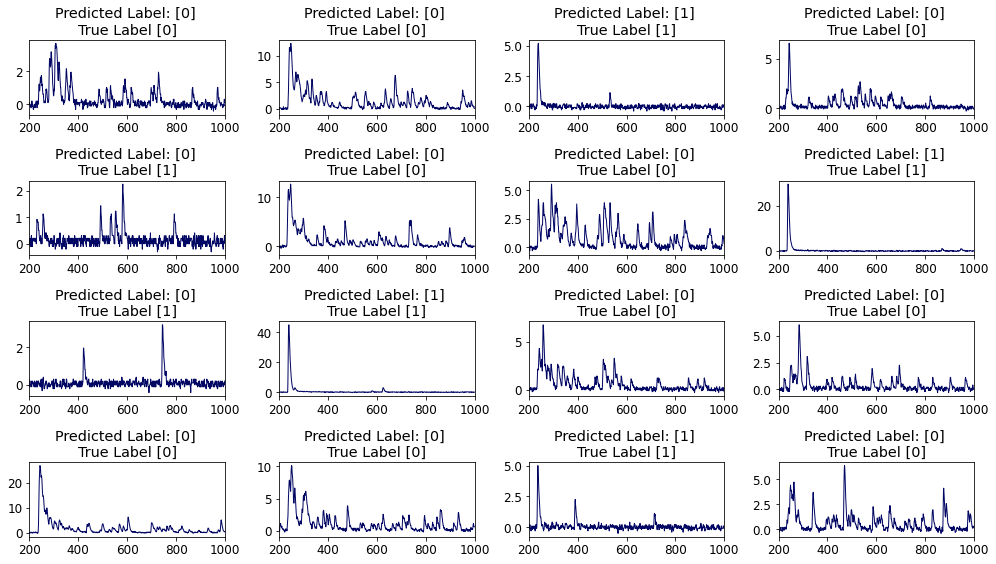

In [13]:
# transform data and use model to output the result(compare it with inputs)
output = model(torch.Tensor(xtest))
pred = output.max(1, keepdim=True)[1].detach().numpy()
output = output.detach().numpy()

xtest_plot = torch.squeeze(xtest)
ytest_plot = torch.squeeze(ytest)
#plt.hist(output)


fig, ax = plt.subplots(4, 4, figsize=(14, 8))
ax = ax.flatten()
print("image shape:", xtest_plot.shape, "\n label shape:", pred.shape)
for i in range(0, 16):
    j = np.random.randint(0, len(pred))
    #print(j)
    ax[i].plot(xtest_plot[j],color='xkcd:darkblue',lw=1)
    ax[i].set_title("Predicted Label: {0} \nTrue Label [{1}]".format(pred[j],ytest_plot[j,0].int()))
    ax[i].set_xlim(200., 1000) #used to zoom around trigger time

fig.tight_layout()

<div class="alert alert-success"> <p>
<b>Discussion</b>
    
As it is shown above, the predicted labels and the true corresponding labels for each signal are highly in line with each other. This means the model is fairly well designed, but futher plots can still be useful to verify this conclusion.
</div>

<div class="alert alert-info"> <p>
<b>Method</b>
    
Another practical diagnostic plot is the ROC-AUC plot. As it shows the evolution of the relation between true positive rate and false positive rate. The integrated area under the curve can simply be used as a quantity to justify the performance of the model. A very helpful function here is `metrics.roc_curve`. With inputs of predicted label and true labels in this case, this function will output the true positive rate and false positive rate while training.
</div>

In [14]:
from sklearn import metrics

def ROC_AUC(M):
    """
    
    """
    # transform data to implement with model
    output = M(torch.Tensor(xtest)).detach().numpy()
    y_true = torch.Tensor(ytest[:,0]).int()[:,0]

    # pull out tpr and fpr from metrics.roc_curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, output[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    # plot the ROC with AUC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (AUC = {0:.1f}%)'.format(roc_auc*100))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

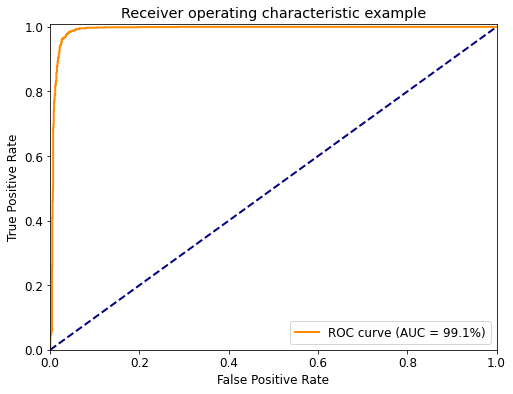

In [15]:
ROC_AUC(model)# call function to plot the ROC for first model

<div class="alert alert-success"> <p>
<b>Discussion</b>
    
As it can be clearly seen from the plot, the AUC is larger than 99% which is exactly in line with the standard given in the introduction.
</div>

<div class="alert alert-info"> <p>
<b>Method</b>
    
A model loss plot is used to make the last verification of the model. It shows how well the model is learning by looking at the shape of the curve as well as comparing the training curve and the testing curve. 

In [16]:
#def loss(n): # train for this many epochs
def loss(n,M):
    lossestrain=[]
    lossestest=[]
    for i in range(n):

        totallosstrain=0
        for data1,target1 in train_loader: # pull a batch from the loader
            output1 = M(data1)
            target1 = target1.data.squeeze()
            target1 = target1[:,0]
            target1 = target1.type(torch.LongTensor)
            totallosstrain += criterion(output1, target1).item()
            optimizer.step() # use gradient info in optimise step
        
        #totallosstrain /= len(train_loader.dataset)
        lossestrain.append(totallosstrain)  

        totallosstest = 0
        for data2,target2 in train_loader:
            output2 = M(data2)
            target2 = target2.data.squeeze()
            target2 = target2[:,0]
            target2 = target2.type(torch.LongTensor)
            totallosstest += criterion(output2, target2).item()
            optimizer.step() # use gradient info in optimise step
        
        #totallosstest /= len(test_loader.dataset)
        lossestest.append(totallosstest)
      
    plt.plot(lossestrain,label = 'train')
    plt.plot(lossestest,label = 'test')
    plt.xlabel("Training epoch")
    plt.ylabel("Loss")
    plt.title('Model Loss')
    plt.legend()
    #plt.savefig("Adam optimizer Loss.jpg")
    #plt.ylim(0)

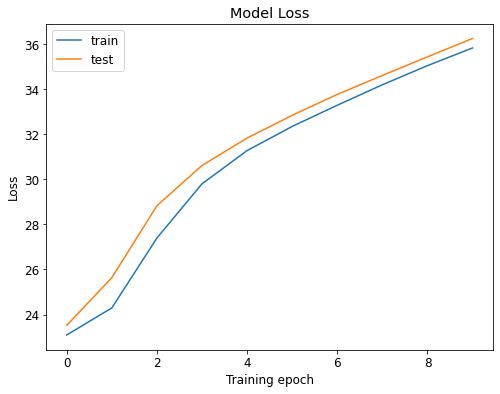

In [17]:
loss(10,model)

<div class="alert alert-success"> <p>
<b>Discussion</b>

The loss plot of this model does not seem too satisfying as the loss is increasing during the process. It is expected to be decreased concave-down curve. This shape might own to the inappropraite choice for optimizer and loss function.$^{[6]}$
    
---
[6] M. Sarwari and k. mg, "Understanding Training and Test Loss Plots", Data Science Stack Exchange, 2021. [Online]. Available: https://datascience.stackexchange.com/questions/52028/understanding-training-and-test-loss-plots. [Accessed: 13- Dec- 2021].
</div>

# <a id="fm1"></a> [Feature maps](#content)

<div class="alert alert-info"> <p>
<b>Method: Feature Map</b>

Another visualization method to justify the model is plotting feature maps. The feature map is plotted by adding filters on each layer. A given filter will move one pixel at a time. Each position results in an activation of the neuron and the output is collected in the feature map. Printing out the feature maps can help to find the effect of each filter on the signals.
    
In this section, feature map will be 
    
</div>

(3076, 2)


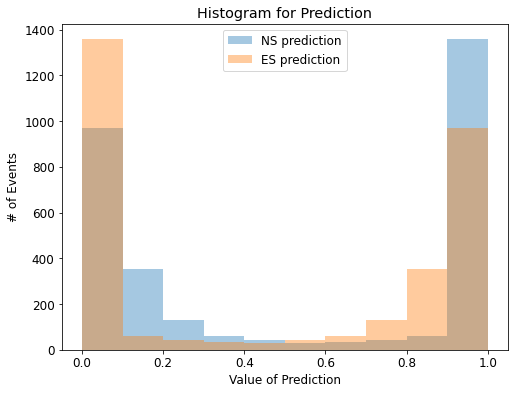

In [35]:
print(output.shape)
plt.hist(output[:,0],label = 'NS prediction',alpha = 0.4)
plt.hist(output[:,1],label = 'ES prediction',alpha = 0.4)
plt.title('Histogram for Prediction')
plt.xlabel('Value of Prediction')
plt.ylabel('# of Events')
plt.legend()

In [19]:
# print out the structure of the model

conv_layers = []
maxpooling_layers = []
model_children=list(model.children())
for children in model_children:
    if (type(children) == nn.Conv1d) or (type(children) == nn.MaxPool1d) :
        print(children)
        conv_layers.append(children)
    elif type(children) == nn.Sequential:
        print(type(children))
        for grandchildren in list(children.children()):
            print(type(grandchildren))
            if (type(grandchildren) == nn.Conv1d) or (type(grandchildren) == nn.MaxPool1d):
                print(type(grandchildren))
                conv_layers.append(grandchildren)

print('len(conv_layers):', len(conv_layers))

<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.conv.Conv1d'>
<class 'torch.nn.modules.batchnorm.BatchNorm1d'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.pooling.MaxPool1d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.container.Sequential'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.dropout.Dropout'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.activation.Softmax'>
len(conv_layers): 4


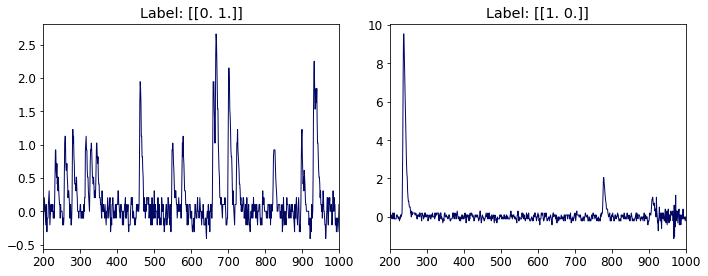

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
# print out two different of signals in their wave forms as a comparison

# plot NS signal
plt.subplot(1,2,1)
plt.plot(xtest.squeeze()[100],color='xkcd:darkblue',lw=1)
plt.title("Label: {}".format(ytest.detach().numpy()[100]))
plt.xlim(200., 1000) #used to zoom around trigger time
# plot ES signal
plt.subplot(1,2,2)
plt.plot(xtest.squeeze()[1],color='xkcd:darkblue',lw=1)
plt.title("Label: {}".format(ytest.detach().numpy()[1]))
plt.xlim(200., 1000) #used to zoom around trigger time

fig.tight_layout()

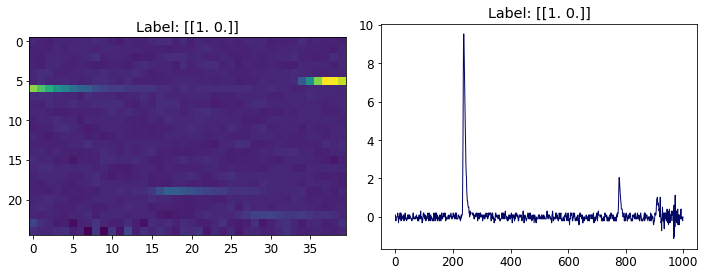

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))
# plot ES signal in both waveform and heatmap and initialize the first layer signal

# initialization of first layer signal
outputs_from_layer = []
sig_from_prev_layer = xtest_plot[1]

# plot heatmap for ES signal
plt.subplot(1,2,1)
plt.imshow(sig_from_prev_layer.reshape(25,40))
sig_from_prev_layer = sig_from_prev_layer.squeeze()
plt.title("Label: {}".format(ytest.detach().numpy()[1]))
# plot waveform for ES signal
plt.subplot(1,2,2)
plt.plot(xtest.squeeze()[1],color='xkcd:darkblue',lw=1)
plt.title("Label: {}".format(ytest.detach().numpy()[1]))

# compute the out put from layers
sig_from_prev_layer = xtest[1].unsqueeze(1)
for layer in conv_layers:
    sig_from_prev_layer = layer(sig_from_prev_layer)
    outputs_from_layer.append(sig_from_prev_layer)

    
fig.tight_layout()

In [22]:
# define a function of waveform feature maps
def waveform(layer_n,n1,n2):
    layer_number = layer_n # value layer numbers
    # define featuremap by output computed in previous cell
    feature_maps = outputs_from_layer[layer_number].detach().numpy()
    # print out useful information for featuremap and significant value of idx for each filters
    print('The shape of feature maps is',feature_maps.shape)
    output_from_filters = feature_maps.sum(axis=1)
    idx_max = output_from_filters.argmax()
    max = output_from_filters.max()
    idx_min = output_from_filters.argmin()
    min = output_from_filters.min()

    print('1st Conv1d layer')
    print('Max, idx: ', max, idx_max)
    print('Min, idx: ', min, idx_min)
    # plot feature maps
    figs, axes = plt.subplots(figsize=[12,8])
    for i in range(feature_maps.shape[1]):
        feature_map = feature_maps[0,i,:]
        plt.subplot(n1,n2,i+1)
        plt.plot(feature_map,color='xkcd:darkblue',lw=1)
        plt.title('idx: {0}'.format(i))

    plt.tight_layout()

The shape of feature maps is (1, 5, 997)
1st Conv1d layer
Max, idx:  10.248375 237
Min, idx:  -1.3862028 966


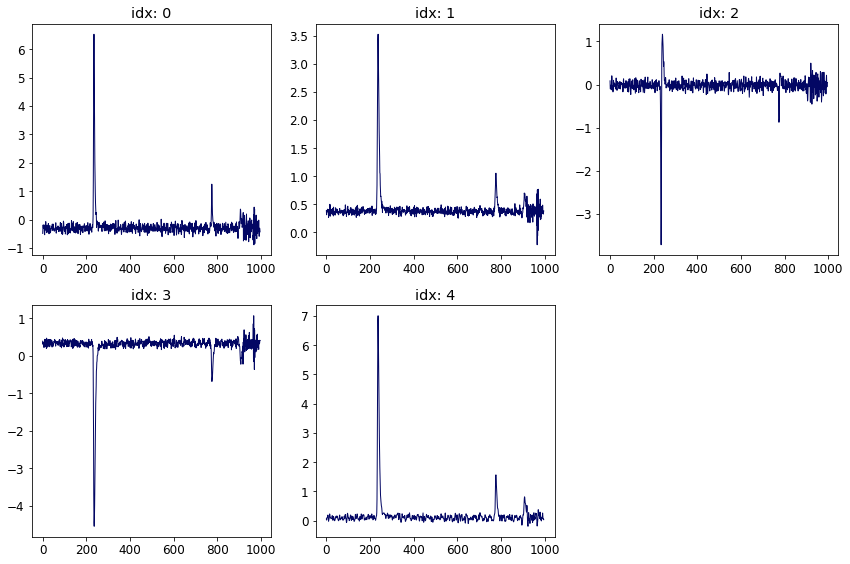

In [23]:
# Feature maps of the first Conv1d layer
# There are 5 filters

waveform(0,2,3)

The shape of feature maps is (1, 5, 124)
1st Conv1d layer
Max, idx:  17.2113 29
Min, idx:  0.6556504 95


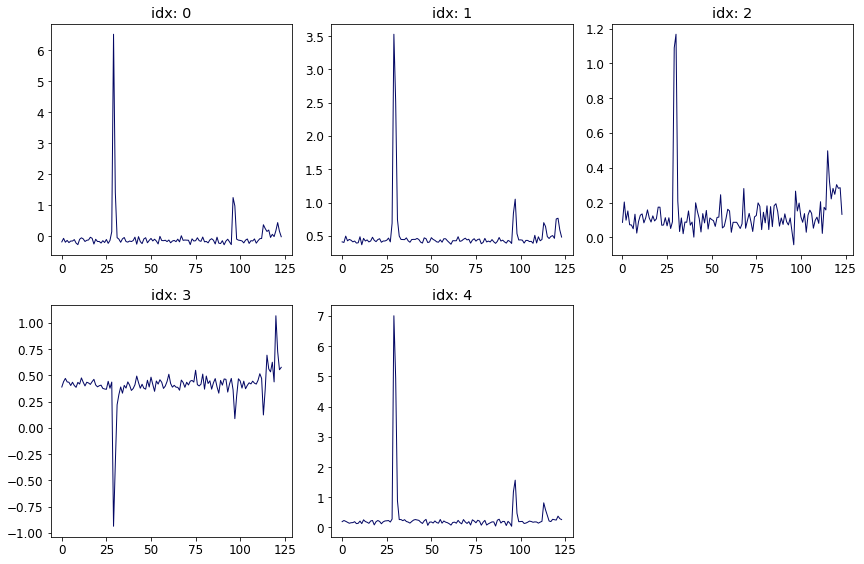

In [24]:
# Feature maps of the first Conv1d layer
# There are 5 filters

waveform(1,2,3)

The shape of feature maps is (1, 30, 15)
1st Conv1d layer
Max, idx:  31.941153 3
Min, idx:  -0.8387096 0


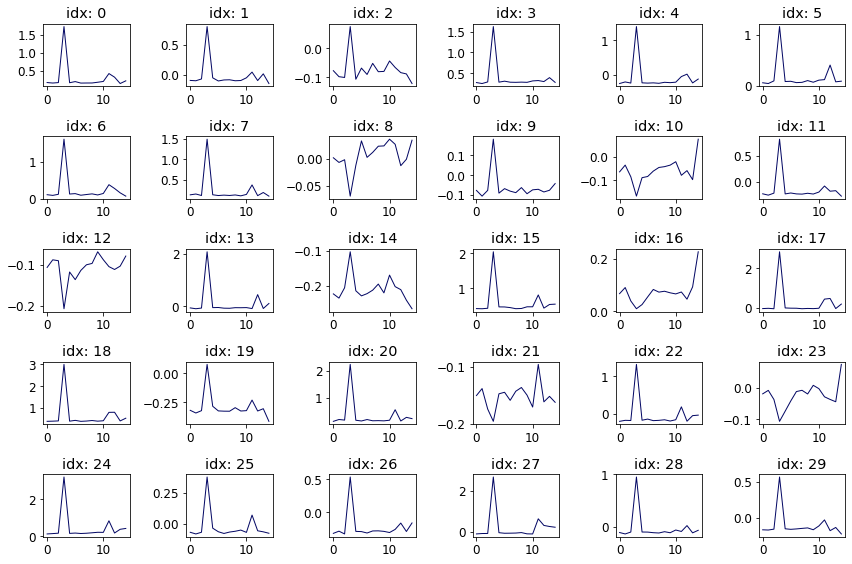

In [25]:
# Feature maps of the first Conv1d layer
# There are 30 filters

waveform(3,5,6)

In [26]:
# similar to waveforms but need to change the shape of input
def heatmaps(layer_n,n,resh1,resh2,n1,n2):
    layer_number = layer_n
    feature_maps = outputs_from_layer[layer_number].detach().numpy()
    print(feature_maps.shape)
    print(len(outputs_from_layer))
    output_from_filters = feature_maps.sum(axis=1)
    idx_max = output_from_filters.argmax()
    max = output_from_filters.max()
    idx_min = output_from_filters.argmin()
    min = output_from_filters.min()

    print('1st Conv1d layer')
    print('Max, idx: ', max, idx_max)
    print('Min, idx: ', min, idx_min)

    figs, axes = plt.subplots(figsize=[20,15])
    for i in range(feature_maps.shape[1]):
        feature_map = feature_maps[0,i,:n]
        plt.subplot(n1,n2,i+1)
        plt.imshow(feature_map.reshape(resh1,resh2))# change shape of featurem map inputs to 2D
        plt.title('idx: {0}'.format(i))

    plt.tight_layout()

(1, 30, 15)
4
1st Conv1d layer
Max, idx:  31.941153 3
Min, idx:  -0.8387096 0


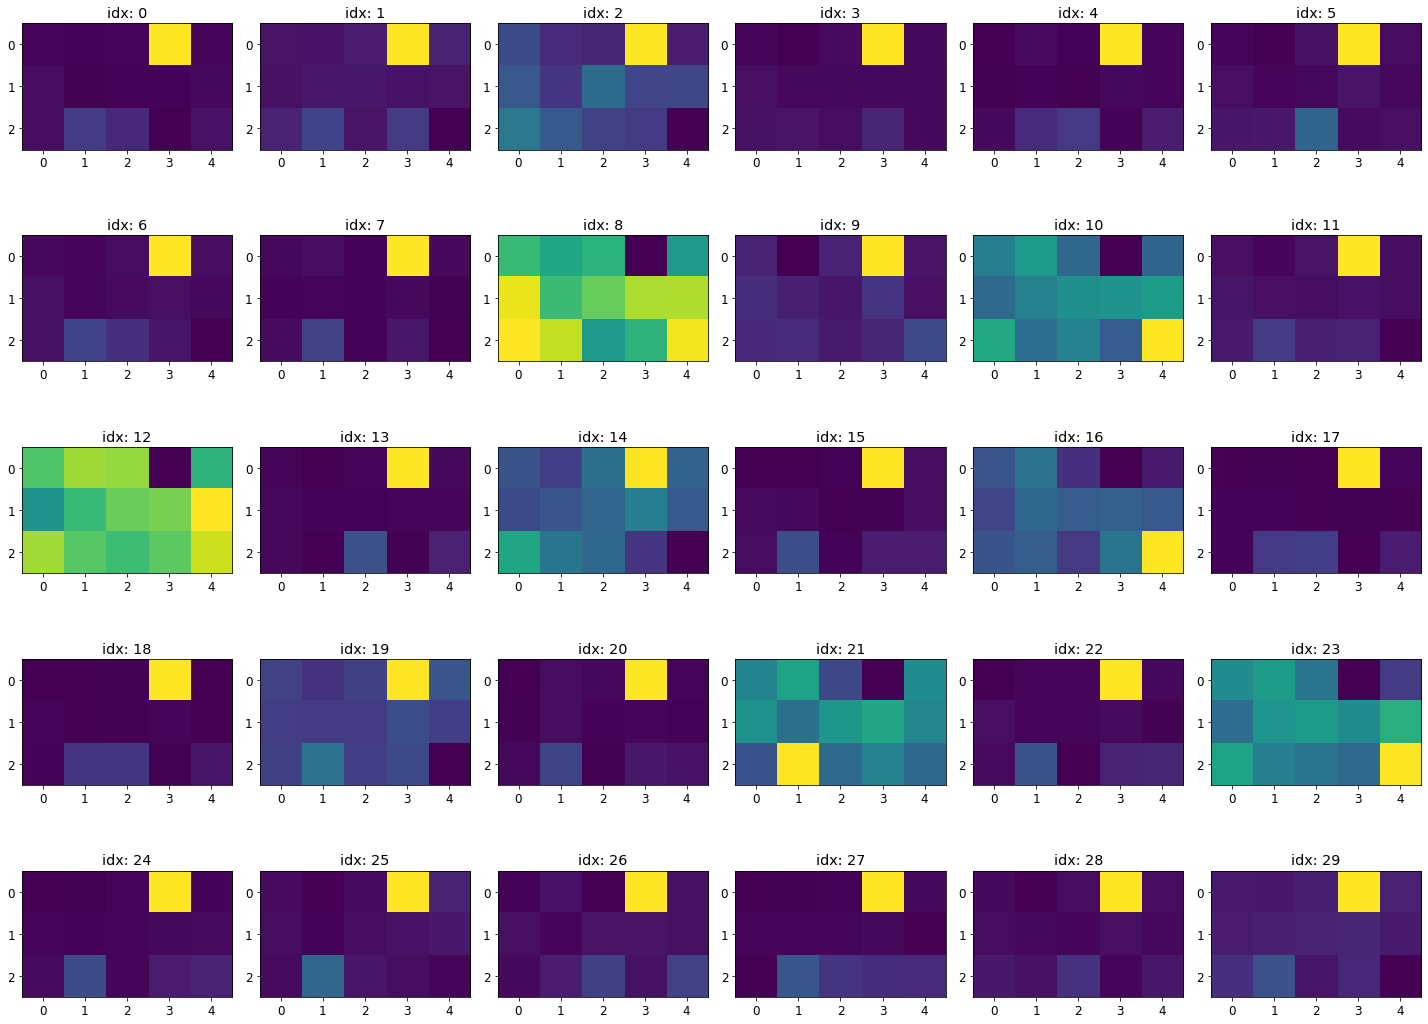

In [27]:
# Feature maps of the first Conv1d layer
# There are 30 filters
heatmaps(3,100,3,5,5,6)

<div class="alert alert-success"> <p>
<b>Discussion</b>

The signals selected to plot the feature maps are ES, By comparing the feature maps, It 
    
---


# <a id="2"></a> [CNN 2](#content)


Here is a repeat of the whole process with different hyperparamters in the CNN structure. All the steps and methods are mostly the same just to see what kind of the impact hyperparameters have on the whole structure. The change in loss function and optimizer was tested and discussed previously so they will be unchanged in this part. This way, it will be practical for comparisons in different combination of hyperparameters.

Therefore, the discussion and conclusion part will be assembled at the end of the section.

# <a id="build2"></a>  [Build CNN](#content)

In [28]:
device = torch.device('cpu')

# here the kernel size and the maxpool parameter is changed as well as the input of the linear layers
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=16),# change the kernelsize and output size of first convlayer
            nn.MaxPool1d(8),
            nn.ReLU(),
            nn.Conv1d(64, 40, kernel_size=2),# change the kernelsize and output size of first convlayer
            nn.BatchNorm1d(40),
            nn.Dropout(), # the probability of an element to be zeroed.
            nn.MaxPool1d(4),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential( # fully connected layer
            nn.Linear(1200, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1,1200)
        x = self.fc_layers(x)
        return x

In [29]:
model2 = Net2().to(device)
optimizer2 = optim.Adagrad(model2.parameters(), lr=0.001)#, momentum=0.5)

In [30]:
print(model2)
numel_list2 = [p2.numel() for p2 in model2.parameters()]
sum(numel_list2), numel_list2

Net2(
  (conv_layers): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(1,))
    (1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv1d(64, 40, kernel_size=(2,), stride=(1,))
    (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=1200, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


(66480, [1024, 64, 5120, 40, 40, 40, 60000, 50, 100, 2])

# <a id="result2"></a> [Results](#content)

In [31]:
xtrain = np.load("x_train.npy")
ytrain = np.load("y_train.npy")
xtest = np.load("x_test.npy")
ytest = np.load("y_test.npy")


xtrain = torch.Tensor(xtrain)
ytrain = torch.Tensor(ytrain)


xtest = torch.Tensor(xtest)
ytest = torch.Tensor(ytest)



xtrain = torch.unsqueeze(xtrain, 1)
ytrain = torch.unsqueeze(ytrain, 1)

xtest = torch.unsqueeze(xtest, 1)
ytest = torch.unsqueeze(ytest, 1)

train2 = TensorDataset(xtrain,ytrain)
test2 = TensorDataset(xtest,ytest)

batchsize2 = 100
train_loader2 = torch.utils.data.DataLoader(dataset=train2, shuffle=True, batch_size=batchsize2) #we can set the batch size for each interation
test_loader2 = torch.utils.data.DataLoader(dataset=test2, shuffle=True, batch_size=batchsize2)

In [32]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train(model2, device, train_loader2, optimizer2, epoch)
    test(model2, device, test_loader2)

Train Epoch: 1 [0/12302 (0%)]	Loss: 0.706051
Train Epoch: 1 [2000/12302 (16%)]	Loss: 0.398394
Train Epoch: 1 [4000/12302 (32%)]	Loss: 0.373952
Train Epoch: 1 [6000/12302 (48%)]	Loss: 0.373219
Train Epoch: 1 [8000/12302 (65%)]	Loss: 0.355631
Train Epoch: 1 [10000/12302 (81%)]	Loss: 0.360087
Train Epoch: 1 [12000/12302 (97%)]	Loss: 0.361950

Test set: Average loss: 0.0036, Accuracy: 3002/3076 (98%)

Train Epoch: 2 [0/12302 (0%)]	Loss: 0.346354
Train Epoch: 2 [2000/12302 (16%)]	Loss: 0.347178
Train Epoch: 2 [4000/12302 (32%)]	Loss: 0.325187
Train Epoch: 2 [6000/12302 (48%)]	Loss: 0.350041
Train Epoch: 2 [8000/12302 (65%)]	Loss: 0.329554
Train Epoch: 2 [10000/12302 (81%)]	Loss: 0.349732
Train Epoch: 2 [12000/12302 (97%)]	Loss: 0.345639

Test set: Average loss: 0.0036, Accuracy: 2993/3076 (97%)

Train Epoch: 3 [0/12302 (0%)]	Loss: 0.348193
Train Epoch: 3 [2000/12302 (16%)]	Loss: 0.369460
Train Epoch: 3 [4000/12302 (32%)]	Loss: 0.336067
Train Epoch: 3 [6000/12302 (48%)]	Loss: 0.342370
Train 

# <a id="plot2"></a>[Plots](#content)

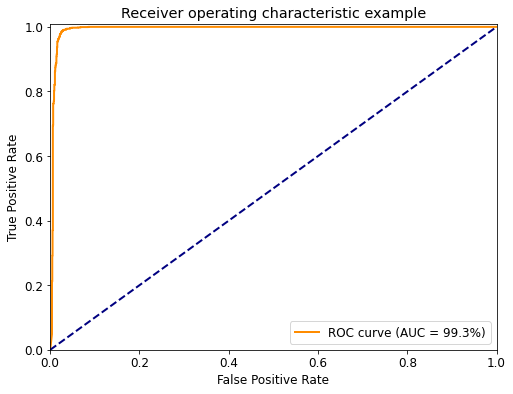

In [33]:
ROC_AUC(model2)

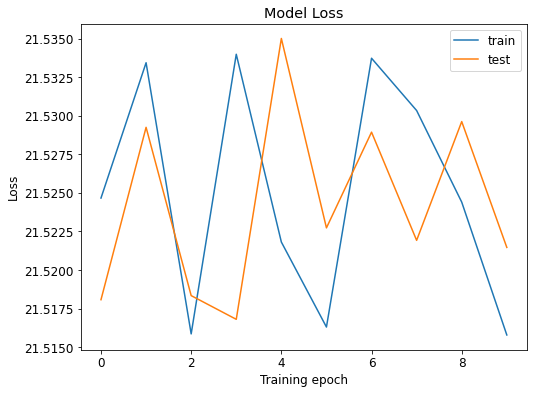

In [34]:
loss(10,model2)

<div class="alert alert-success"> <p>
<b>Discussion and conclusion on performance</b>

- The most noticing difference of this model is the performance of the model loss.
- All the other performance of the second model is similar to the previous one, only with very small variations. 
- Small variation in the result for the same model might be caused by the initialization of the weight. Therefore, even with the same seed, the result can never be the same for each run.
- In this project, the hyperparameter choices in the first model might be more appropriate.
- The choice for optimizer and loss function should be improved in the future.
</div>

# <a id="bc"></a>[Best CNN structure for single chanel classification](#content)

https://stats.stackexchange.com/questions/403502/is-it-a-good-idea-to-use-cnn-to-classify-1d-signal

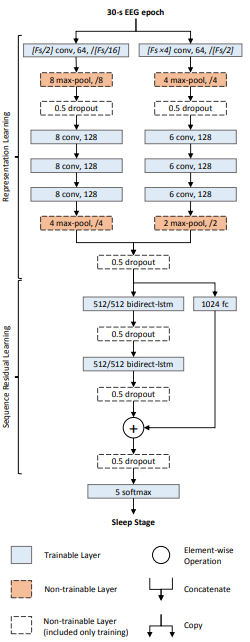

<div class="alert alert-success"> <p>
    
# <a id="dc"></a> [Summary and Conclusions](#content)

The convolutional neural network built in this project should be able to classify two signals in the form of 1D waveform with certain level of justification of the performance. The process of setting up the dataset and creating the CNN structure are the most cruicial and challenging part:

1. For data importing
 - It is important to find out the way combining the datasets as training part and testing part. The signals and corresponding labels are both needed for training part and testing part. Print out the shape of raw dataset was significantly helpful in this case. 
 - For 1D signals, the chanel columns might be skipped so using the `torch.unsqueeze()` function here to add chanels to data is neccessary.

2. For building structure.
 - It might take a long time to figure out the combinition of hyperparameters but once the combinition works, adding a normalization layer in convolutional layers is required for the training.
 - Apart from hyperparameters, the choices of optimizer and loss function was also quite tricky and needs further research to support the conclusion.
 - There would be small variations in performance or accuracy even in the same model due to the initialization of weight for each run. This error of each model is worth to be analyzed.
 - The loss plot for each model showed terrible training process, a solution for this is to change loss function or optimizer. 
 
In conclusion, although most of the CNN models in this project possessed good performance in accuray of predictions, the models were either trained with too much loss or stop learning too soon. Way to modify the model was stated in the discussions several times. Change the structure of layers, adjusting the hyperparameter, change optimizer and change loss function. There are literatures stating out the method to find out the best solution, but most of them is totally empirical since all the parameters in the model are correlate to the others. It is worth trying with different combination of parameters to find the model with best performance.
    
    
</div>